In [300]:
import matplotlib.pyplot as plt
import numpy as np
import pytz
import pandas as pd
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timezone
from dataclasses import dataclass, field

In [301]:
url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json-pretty"
#url = "active.json"
data = pd.read_json(url).to_numpy()

### Kepler equation 

$M=E−e⋅sin⁡(E)$

- "**$M$**" is the mean anomaly
- "**$E$**" is the eccentric anomaly
- "**$e$**" is the eccentricity

### Newton-Raphson method

Initialisation: $E_0​=M$

$f(E_n​)=E_n​−e⋅sin(E_n​)−M$

$f^{'}(E_n)=1−e⋅cos⁡(E_n)$

$E_{n+1}​=E_n​−\frac{f(E_n​)}{f^{'}(E_n​)}$​

$E_{n+1}​=E_n​−\frac{E_n​−e⋅sin(E_n​)−M}{1−e⋅cos⁡(E_n)}$​

$E_{n+1}​=E_n​−\Delta{E_n}$​

help sources p75: https://pagespro.isae-supaero.fr/IMG/pdf/MecaCel_IS101_2011.pdf

In [302]:
@dataclass
class VEC_3:
    XYZ : np.ndarray
    
    @property
    def X(self):
        return self.XYZ[0,:]
    
    @property
    def Y(self):
        return self.XYZ[1,:]
    
    @property
    def Z(self):
        return self.XYZ[2,:]

@dataclass
class VEC_2:
    LON_LAT : np.ndarray
    
    @property
    def LON(self):
        return self.LON_LAT[0,:]
    
    @property
    def LAT(self):
        return self.LON_LAT[1,:]
 
@dataclass
class Position:
    orbital : VEC_3 = field(init=False)
    inertial : VEC_3 = field(init=False)
    geografic : VEC_2 = field(init=False)
    
@dataclass
class Speed:
    orbital : VEC_3 = field(init=False)
    inertial : VEC_3 = field(init=False)
    

In [392]:
@dataclass
class Satellite:
    NAME: str
    NORA_ID: int
    EPOCH: str
    MEAN_MOTION: float
    ECCENTRICITY: float
    INCLINATION: float
    RA_OF_ASC_NODE: float
    ARG_OF_PERICENTER: float
    MEAN_ANOMALY: float
    MUE: float = 398600.44
    EARTH_MASS: float = 5.972e24
    G: float = 6.67384e-11
    NB_POINTS: int = 1000
    NB_ORBITS: int = 1
    position = Position
    speed = Speed
    
    d1: datetime = field(init=False)
    dt: float = field(init=False)
    PERIOD: float = field(init=False)
    time: np.ndarray = field(init=False)
    MEAN_ANOMALY_future: np.ndarray = field(init=False)
    ECC_ANOMALY_future: np.ndarray = field(init=False)

    def __post_init__(self):
        self.parse_epoch()
        self.convert_degrees_to_radians()
        self.calculate_orbital_parameters()
        self.initial_state_parameters()

    def parse_epoch(self):
        self.d1 = datetime.strptime(self.EPOCH, '%Y-%m-%dT%H:%M:%S.%f')
        self.d2 = datetime.now(timezone.utc)
        self.dt = (self.d2 - self.d1.replace(tzinfo=pytz.UTC)).total_seconds()

    def convert_degrees_to_radians(self):
        self.ECCENTRICITY = np.deg2rad(self.ECCENTRICITY)
        self.INCLINATION = np.deg2rad(self.INCLINATION)
        self.RA_OF_ASC_NODE = np.deg2rad(self.RA_OF_ASC_NODE)
        self.ARG_OF_PERICENTER = np.deg2rad(self.ARG_OF_PERICENTER)
        self.MEAN_ANOMALY = np.deg2rad(self.MEAN_ANOMALY)

    def calculate_orbital_parameters(self):
        self.PERIOD = (1 / self.MEAN_MOTION) * 86400  # seconds in a day
        self.time = np.linspace(0, self.NB_ORBITS * self.PERIOD, self.NB_POINTS)
        self.MEAN_MOTION_SI = 2 * np.pi / self.PERIOD
        self.SEMI_MAJOR_AXIS = ((self.MUE / (self.MEAN_MOTION_SI ** 2)) ** (1 / 3)) * 1000
        self.MEAN_MOTION = np.sqrt(self.EARTH_MASS * self.G / self.SEMI_MAJOR_AXIS ** 3)
        self.MEAN_ANOMALY += self.MEAN_MOTION * self.dt

    def calcul_orbital_mecanic(self, ANOMALY):
        r = self.SEMI_MAJOR_AXIS * (1 - self.ECCENTRICITY * np.cos(ANOMALY))
        cos_E = np.cos(ANOMALY)
        sin_E = np.sin(ANOMALY)
        x = self.SEMI_MAJOR_AXIS * (cos_E - self.ECCENTRICITY)
        y = self.SEMI_MAJOR_AXIS * np.sqrt(1 - self.ECCENTRICITY**2) * sin_E
        xdot = -sin_E * self.MEAN_MOTION * self.SEMI_MAJOR_AXIS**2 / r
        ydot = np.sqrt(1 - self.ECCENTRICITY**2) * cos_E * self.MEAN_MOTION * self.SEMI_MAJOR_AXIS**2 / r
        return np.vstack((x, y, np.zeros_like(ANOMALY))), np.vstack((xdot, ydot, np.zeros_like(ANOMALY)))
    
    def calcul_inertial_mecanic(self, ANOMALY, i):
        R_total = self.R_RA_OF_ASC_NODE @ self.R_INCLINATION @ self.R_ARG_OF_PERICENTER
        xyz = self.ROT_EARTH(self.time[i]) @ R_total @ self.calcul_orbital_mecanic(ANOMALY)[0]
        xyzdot = self.ROT_EARTH(self.time[i]) @ R_total @ self.calcul_orbital_mecanic(ANOMALY)[1]
        return xyz.reshape(3,1), xyzdot.reshape(3,1)
    
    def calcul_geografic_mecanic(self, ANOMALY, i):
        xyz = self.calcul_inertial_mecanic(ANOMALY, i)[0]
        p=np.linalg.norm(xyz,axis=0)
        a = 6378137
        b = 6356752.314235
        f = (a - b) / a
        lon = np.rad2deg(np.arctan2(xyz[1],xyz[0]))-self.GMST
        lat = np.rad2deg(np.arcsin(xyz[2]/p))* (1 - f * f)
        if lon > 180:
            lon -= 360
        elif lon < -180:
            lon += 360
        return np.vstack((lon,lat))
        
    def initial_state_parameters(self):   
        self.position.orbital = VEC_3(self.calcul_orbital_mecanic(self.MEAN_ANOMALY)[0])
        self.speed.orbital = VEC_3(self.calcul_orbital_mecanic(self.MEAN_ANOMALY)[1])
        self.position.inertial = VEC_3(self.calcul_inertial_mecanic(self.MEAN_ANOMALY, 0)[0])
        self.speed.inertial = VEC_3(self.calcul_inertial_mecanic(self.MEAN_ANOMALY, 0)[1])
        self.position.geografic = VEC_2(self.calcul_geografic_mecanic(self.MEAN_ANOMALY, 0))
        
    
    @property
    def R_INCLINATION(self) -> np.ndarray:
        return np.array([[1, 0, 0],
                         [0, np.cos(-self.INCLINATION), np.sin(-self.INCLINATION)],
                         [0, -np.sin(-self.INCLINATION), np.cos(-self.INCLINATION)]])

    @property
    def R_RA_OF_ASC_NODE(self) -> np.ndarray:
        return np.array([[np.cos(-self.RA_OF_ASC_NODE), np.sin(-self.RA_OF_ASC_NODE), 0],
                         [-np.sin(-self.RA_OF_ASC_NODE), np.cos(-self.RA_OF_ASC_NODE), 0],
                         [0, 0, 1]])

    @property
    def R_ARG_OF_PERICENTER(self) -> np.ndarray:
        return np.array([[np.cos(-self.ARG_OF_PERICENTER), np.sin(-self.ARG_OF_PERICENTER), 0],
                         [-np.sin(-self.ARG_OF_PERICENTER), np.cos(-self.ARG_OF_PERICENTER), 0],
                         [0, 0, 1]])
    @property
    def GMST(self):
        a = (14 - self.d1.month) // 12
        y = self.d1.year + 4800 - a
        m = self.d1.month + 12 * a - 3
        JD = (self.d1.day + ((153 * m + 2) // 5) + 365 * y + (y // 4) - (y // 100) + (y // 400) - 32045 +
            (self.d1.hour - 12) / 24.0 + self.d1.minute / 1440.0 + self.d1.second / 86400.0)
        T = (JD - 2451545.0) / 36525.0
        GMST = (280.46061837 +
                360.98564736629 * (JD - 2451545.0) +
                T ** 2 * (0.000387933 - T / 38710000))
        GMST %= 360
        return GMST

    def ROT_EARTH(self, t):
        fi_earth = (self.dt + t) * 2 * np.pi * (1 + 1 / 365.25) / 86400
        return np.array([[np.cos(fi_earth), np.sin(fi_earth), 0],
                         [-np.sin(fi_earth), np.cos(fi_earth), 0],
                         [0, 0, 1]])

    def future_it(self):
        self.MEAN_ANOMALY_future = self.MEAN_ANOMALY + self.MEAN_MOTION * self.time
        epsilon = 1e-6
        
        for i in range(self.NB_POINTS):
            ECCENTRIC_ANOMALY_N = self.MEAN_ANOMALY_future[i]
            while True:
                delta = (ECCENTRIC_ANOMALY_N - self.ECCENTRICITY * np.sin(ECCENTRIC_ANOMALY_N) - self.MEAN_ANOMALY_future[i]) / \
                        (1 - self.ECCENTRICITY * np.cos(ECCENTRIC_ANOMALY_N))
                ECCENTRIC_ANOMALY_N -= delta
                if np.abs(delta) < epsilon:
                    break
        
            self.position.orbital.XYZ = np.hstack((self.position.orbital.XYZ, self.calcul_orbital_mecanic(ECCENTRIC_ANOMALY_N)[0]))
            self.speed.orbital.XYZ = np.hstack((self.speed.orbital.XYZ, self.calcul_orbital_mecanic(ECCENTRIC_ANOMALY_N)[1]))
            self.position.inertial.XYZ = np.hstack((self.position.inertial.XYZ, self.calcul_inertial_mecanic(ECCENTRIC_ANOMALY_N, i)[0]))            
            self.speed.inertial.XYZ = np.hstack((self.speed.inertial.XYZ, self.calcul_inertial_mecanic(ECCENTRIC_ANOMALY_N, i)[1]))
            self.position.geografic.LON_LAT = np.hstack((self.position.geografic.LON_LAT, self.calcul_geografic_mecanic(ECCENTRIC_ANOMALY_N, i)))

In [396]:
sat = Satellite(*data[9][:9], NB_ORBITS=3)
sat.future_it()

In [397]:
lon_plot = sat.position.geografic.LON.tolist()
lat_plot = sat.position.geografic.LAT.tolist()
for ind_i in range(0,len(lon_plot)-1):
    if np.abs(lon_plot[ind_i]+lon_plot[ind_i+1])<np.abs(lon_plot[ind_i]):
        lon_plot[ind_i]=np.nan
        lat_plot[ind_i]=np.nan

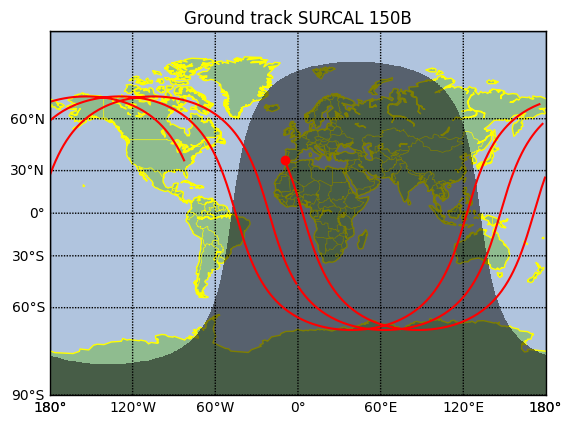

In [398]:
plt.figure()
map = Basemap(projection='mill',lon_0=0)
map.drawcoastlines(color="yellow")
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
map.drawmapboundary(fill_color='lightsteelblue')
map.fillcontinents(color='darkseagreen',lake_color='lightsteelblue')
map.drawcountries(color="yellow")
CS=map.nightshade(sat.d2)
x, y = map(lon_plot, lat_plot)
x_0, y_0 = map(lon_plot[0], lat_plot[0])
plt.plot(x, y, color="r")
plt.plot(x_0, y_0, color="r", marker="o")
plt.title(f"Ground track {sat.NAME}")
plt.show()